In [1]:
#Initiate libraries needed for script
import glob, os
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib as matplotlib
import seaborn as sns
import matplotlib.cm as cm
from numpy import linspace
import statistics
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import scipy
from scipy.signal import find_peaks

#functions used in this script:

#opening directory and grabbing all text files with wildcard
#in this case it is all with DMPC_LUV in the name
#function to pull all files (X and Y coordinates) for text files with wildcard matching input
def csv_pull(files, cols, trim):
    li = []
    f = sorted(glob.glob(files))
    file_titles = []
    for n in f:
        df = pd.read_csv(n, skiprows = 54, sep="\t", names = cols)
        temp = n[trim[0]:trim[1]]
        #temp = n.strip(files)
        file_titles.append(temp)
        li.append(df)
        
    return li, file_titles

#Calculate the general polarisation (GP) of Laurdan from spectra
def GP_calc(arr):
    i = 0
    final = []
    #loop through arrays
    while i < len(arr):
        #find the position of 440nm and 490nm
        temp = np.where(arr[i]['x'] == 440.00)
        x440 = temp[0][0]
        temp = np.where(arr[i]['x'] == 490.00)
        x490 = temp[0][0]
        #Use this position to find the y value at this point (give or take some areas)
        #Due to some slight shifting, it is mroe accurate to take an average of 437-443
        #The maxima is then found of this range, as this is the 'peak'
        temp_440 = max([
            arr[i]['y'][x440-3], arr[i]['y'][x440-2], arr[i]['y'][x440-1], arr[i]['y'][x440],
            arr[i]['y'][x440+1], arr[i]['y'][x440+2], arr[i]['y'][x440+3]
        ])
        temp_490 = max([
            arr[i]['y'][x490-3], arr[i]['y'][x490-2], arr[i]['y'][x490-1], arr[i]['y'][x490],
            arr[i]['y'][x490+1], arr[i]['y'][x490+2], arr[i]['y'][x490+3]
        ])
        
        #Actual calculation occurs here
        temp1 = (temp_440-temp_490)
        temp2 = (temp_440+temp_490)
        final.append(temp1/temp2)
        
        #This is a counter to ensure all temperatures get the GP calculated
        i = i+1
        
    #And it is sent back when the loop is finished
    return final
#Standard colours used within the thesis
colors = [sns.xkcd_rgb["black"], #0, black
          sns.xkcd_rgb["cerulean"], #1 blue
          sns.xkcd_rgb["moss green"], #2 dark green
          sns.xkcd_rgb["rust"], #3 dark red
          sns.xkcd_rgb["slate"], #4 slate/grey-blue
          sns.xkcd_rgb["mustard"], #5 yellow
          sns.xkcd_rgb["tangerine"], # 6 tangerine ***** this is for SMA 3:1
          sns.xkcd_rgb["coral"], #7 pink-red ***** This is for SMA 2:1
          sns.xkcd_rgb["grass"], #8 grass (brighter green)***** This is for DIBMA
          sns.xkcd_rgb["bright blue"], #9  bright blue *****This is for PMA
          sns.xkcd_rgb["olive green"] #10 olive green
         ]

#standard plotting style used within this thesis.
sns.set_style("white")
sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [2]:
#Input the files, and standardised where they are trimmed and column names
cols = ['x','y']
trim = [0,13]

#DMPC
DMPC_LUV, files = csv_pull('1DMPC_LUV_*.txt', cols, trim)
DMPC_LQ, files = csv_pull('DMPC_LQ_*.txt', cols, trim)
DMPC_21, files = csv_pull('DMPC_21SMA_*.txt', cols, trim)
DMPC_D, files = csv_pull('DMPC_DIBMA_*.txt', cols, trim)

#Mix
mix_LUV, files = csv_pull('MIX_LUV_*.txt', cols, trim)
mix_LQ, files = csv_pull('MIX_LQ_*.txt', cols, trim)
mix_21, files = csv_pull('MIX_21SMA_*.txt', cols, trim)
mix_D, files = csv_pull('MIX_DIBMA_*.txt', cols, trim)

#DLPC
DLPC_LUV, files = csv_pull('DLPC_LUV_*.txt', cols, trim)
DLPC_LQ, files = csv_pull('DLPC_LQ_*.txt', cols, trim)
DLPC_21, files = csv_pull('DLPC_21SMA_*.txt', cols, trim)
DLPC_D, files = csv_pull('DLPC_DIBMA_*.txt', cols, trim)

#LUV = LUVs, LQ = SMA 3:1, 21 = SMA 2:1, D = DIBMA

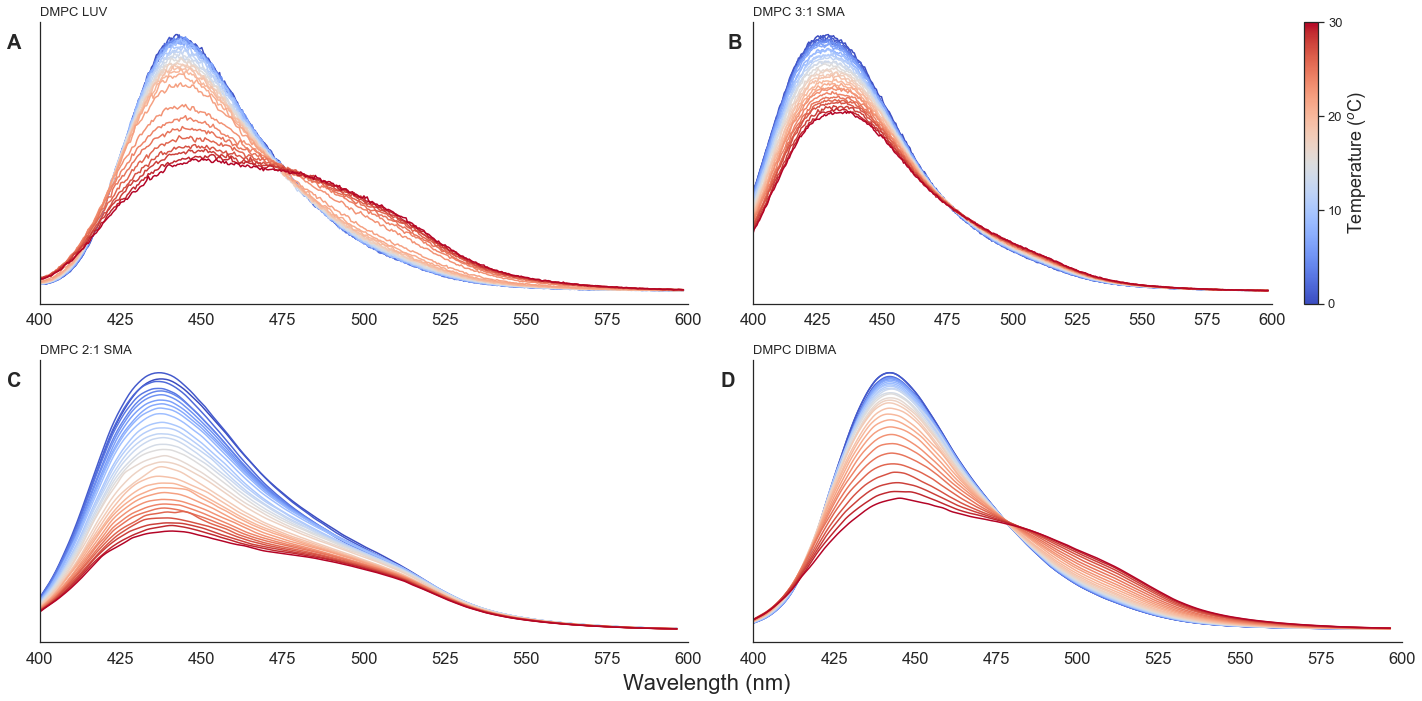

In [19]:
#Begin the plotting!

#Starting with DMPC membranes

#Firstly make a count of the number of temperature points (len(files)),
#then use this value to generate a unique colour between blue-red for a pretty graph
i = len(files)
coloring = [cm.coolwarm(x) for x in linspace(0, 1, i)]

#Plotting Figure and giving a title
fig, axs = plt.subplots(2, 2, figsize=(20, 10), frameon = True)

i = len(files)
j = 0
#As it is so many files, a loop is needed to plot each in turn
#Coordinate system of figure means this can be done with a single loop for all 4 samples
while j < i:
    axs[0][0].plot(DMPC_LUV[j]['x'], DMPC_LUV[j]['y'], color = coloring[j], lw = 1.5)
    axs[0][1].plot(DMPC_LQ[j]['x'], DMPC_LQ[j]['y'], color = coloring[j], lw = 1.5)
    axs[1][0].plot(DMPC_21[j]['x'], DMPC_21[j]['y'], color = coloring[j], lw = 1.5)
    axs[1][1].plot(DMPC_D[j]['x'], DMPC_D[j]['y'], color = coloring[j], lw = 1.5)
    j = j+1

#plot color bar (and label it)
c_m = matplotlib.cm.coolwarm
norm = matplotlib.colors.Normalize(
vmin=np.min(np.linspace(0,30,i)),
vmax=np.max(np.linspace(0,30,i)))
s_m = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm)
s_m.set_array([])

#The ax here is the plot chosen to have the colour bar within it (the top right in this case)
ticks=[i for i in np.arange(0, 31, 10)]
cbar = plt.colorbar(s_m, ticks = ticks, ax = axs[0,1])
cbar.ax.tick_params(labelsize=13) 
cbar.set_label('Temperature ($^{o}$C)', rotation=90)

#labelling the plots
axs[0,0].set_title("DMPC LUV", fontsize = 13, loc = 'left')
axs[0,1].set_title("DMPC 3:1 SMA", fontsize = 13, loc = 'left')
axs[1,0].set_title("DMPC 2:1 SMA", fontsize = 13, loc = 'left')
axs[1,1].set_title("DMPC DIBMA", fontsize = 13, loc = 'left')

#Remocing the ticks as this is more qualitative than quantitative
axs[0,0].set_yticks([])
axs[0,1].set_yticks([])
axs[1,0].set_yticks([])
axs[1,1].set_yticks([])

#Standardise the layout to make visual comparison easier, and prettier
axs[0,0].set_xlim(400,600)
axs[0,1].set_xlim(400,600)
axs[1,0].set_xlim(400,600)
axs[1,1].set_xlim(400,600)

#Label them all for each reference in the thesis
height = axs[0,0].axis()
axs[0,0].text(x = 390, y = 0.9*height[3], s = "A", weight = "bold", fontsize = 20)
height = axs[0,1].axis()
axs[0,1].text(x = 390, y = 0.9*height[3], s = "B", weight = "bold", fontsize = 20)
height = axs[1,0].axis()
axs[1,0].text(x = 390, y = 0.9*height[3], s = "C", weight = "bold", fontsize = 20)
height = axs[1,1].axis()
axs[1,1].text(x = 390, y = 0.9*height[3], s = "D", weight = "bold", fontsize = 20)

axs[1,0].text(x = 580, y = -160, s = "Wavelength (nm)", fontsize = 22)
#Fix the spacing between the plots, and show it
fig.tight_layout()
plt.subplots_adjust(hspace=0.2, wspace=0.1)
sns.despine()

#plt.savefig('DMPC_Heatmaps.png', format='png', dpi=300, bbox_inches="tight")
plt.show()

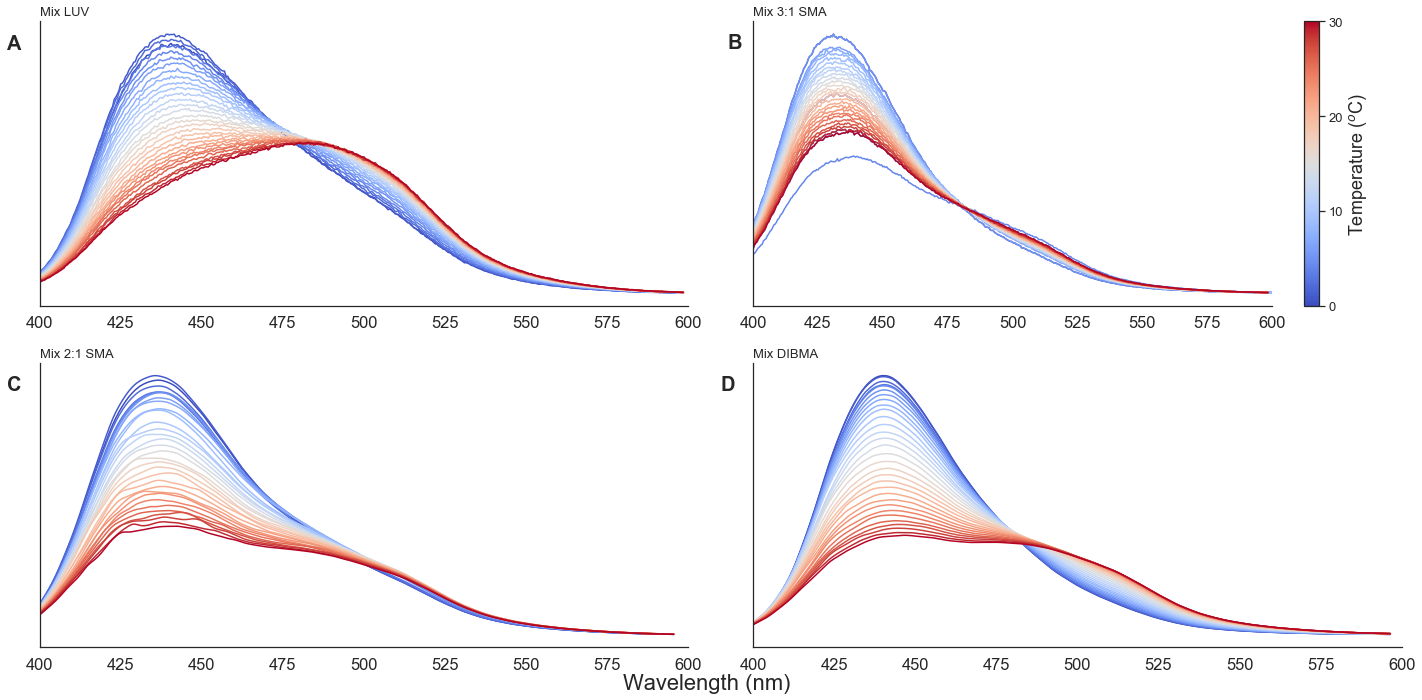

In [20]:
#Now onto the DMPC+DLPC membranes (this was not shown in the thesis as it wasn't realy necessary)

i = len(files)
coloring = [cm.coolwarm(x) for x in linspace(0, 1, i)]

#Plotting Figure and giving a title
fig, axs = plt.subplots(2, 2, figsize=(20, 10), frameon = True)

i = len(files)
j = 0
while j < i:
    axs[0][0].plot(mix_LUV[j]['x'], mix_LUV[j]['y'], color = coloring[j], lw = 1.5)
    axs[0][1].plot(mix_LQ[j]['x'], mix_LQ[j]['y'], color = coloring[j], lw = 1.5)
    axs[1][0].plot(mix_21[j]['x'], mix_21[j]['y'], color = coloring[j], lw = 1.5)
    axs[1][1].plot(mix_D[j]['x'], mix_D[j]['y'], color = coloring[j], lw = 1.5)
    
    j = j+1

#plot color bar
c_m = matplotlib.cm.coolwarm
norm = matplotlib.colors.Normalize(
vmin=np.min(np.linspace(0,30,i)),
vmax=np.max(np.linspace(0,30,i)))
s_m = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm)
s_m.set_array([])

ticks=[i for i in np.arange(0, 31, 10)]
cbar = plt.colorbar(s_m, ticks = ticks, ax = axs[0,1])
cbar.ax.tick_params(labelsize=13) 
cbar.set_label('Temperature ($^{o}$C)', rotation=90)

axs[0,0].set_title("Mix LUV", fontsize = 13, loc = 'left')
axs[0,1].set_title("Mix 3:1 SMA", fontsize = 13, loc = 'left')
axs[1,0].set_title("Mix 2:1 SMA", fontsize = 13, loc = 'left')
axs[1,1].set_title("Mix DIBMA", fontsize = 13, loc = 'left')

axs[0,0].set_yticks([])
axs[0,1].set_yticks([])
axs[1,0].set_yticks([])
axs[1,1].set_yticks([])

axs[0,0].set_xlim(400,600)
axs[0,1].set_xlim(400,600)
axs[1,0].set_xlim(400,600)
axs[1,1].set_xlim(400,600)

height = axs[0,0].axis()
axs[0,0].text(x = 390, y = 0.9*height[3], s = "A", weight = "bold", fontsize = 20)
height = axs[0,1].axis()
axs[0,1].text(x = 390, y = 0.9*height[3], s = "B", weight = "bold", fontsize = 20)
height = axs[1,0].axis()
axs[1,0].text(x = 390, y = 0.9*height[3], s = "C", weight = "bold", fontsize = 20)
height = axs[1,1].axis()
axs[1,1].text(x = 390, y = 0.9*height[3], s = "D", weight = "bold", fontsize = 20)

axs[1,0].text(x = 580, y = -170, s = "Wavelength (nm)", fontsize = 22)

fig.tight_layout()
plt.subplots_adjust(hspace=0.2, wspace=0.1)
sns.despine()

#plt.savefig('mixed_Heatmaps.png', format='png', dpi=300, bbox_inches="tight")
plt.show()

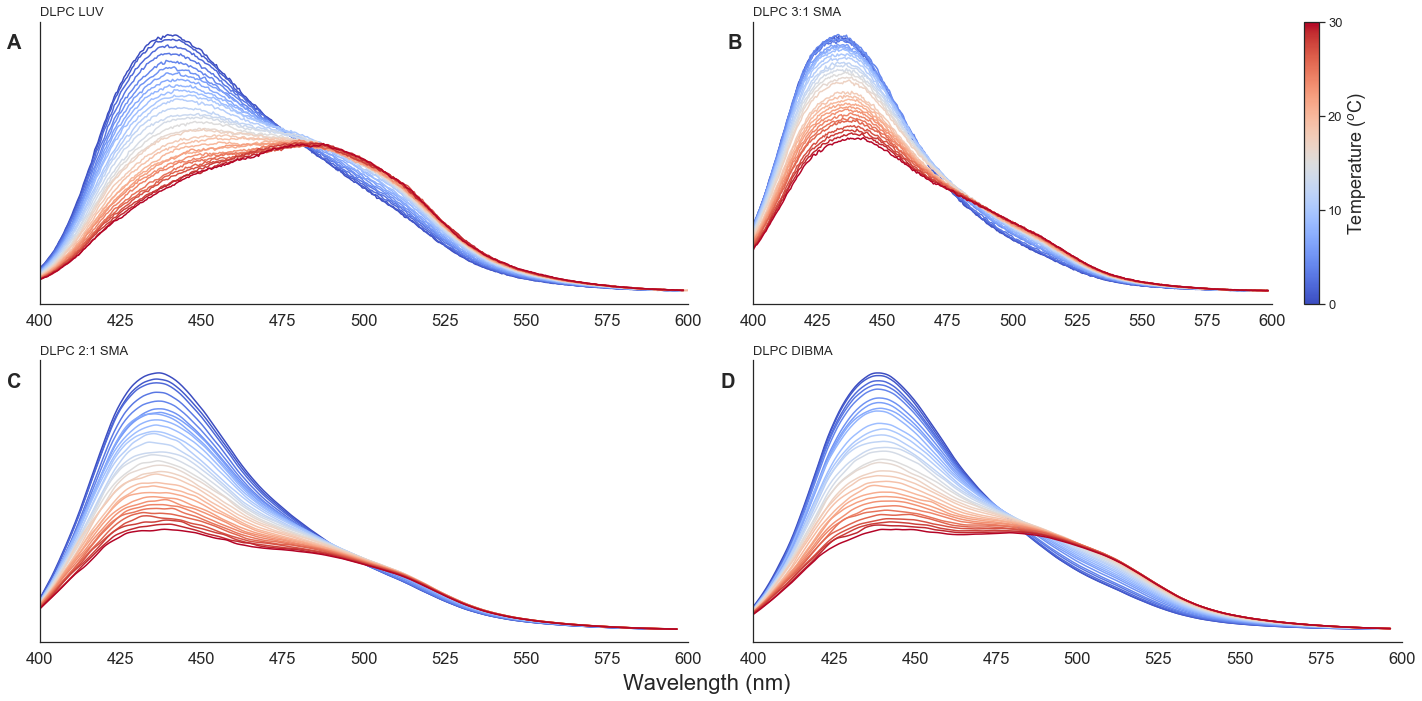

In [17]:
#And now onto the dLPC membranes alone, exactly the same as the pevious two.

i = len(files)
coloring = [cm.coolwarm(x) for x in linspace(0, 1, i)]

#Plotting Figure and giving a title
fig, axs = plt.subplots(2, 2, figsize=(20, 10), frameon = True)

i = len(files)
j = 0
while j < i:
    axs[0][0].plot(DLPC_LUV[j]['x'], DLPC_LUV[j]['y'], color = coloring[j], lw = 1.5)
    axs[0][1].plot(DLPC_LQ[j]['x'], DLPC_LQ[j]['y'], color = coloring[j], lw = 1.5)
    axs[1][0].plot(DLPC_21[j]['x'], DLPC_21[j]['y'], color = coloring[j], lw = 1.5)
    axs[1][1].plot(DLPC_D[j]['x'], DLPC_D[j]['y'], color = coloring[j], lw = 1.5)
    
    j = j+1
#plot color bar
c_m = matplotlib.cm.coolwarm
norm = matplotlib.colors.Normalize(
vmin=np.min(np.linspace(0,30,i)),
vmax=np.max(np.linspace(0,30,i)))
s_m = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm)
s_m.set_array([])

ticks=[i for i in np.arange(0, 31, 10)]
cbar = plt.colorbar(s_m, ticks = ticks, ax = axs[0,1])
cbar.ax.tick_params(labelsize=13) 
cbar.set_label('Temperature ($^{o}$C)', rotation=90)

axs[0,0].set_title("DLPC LUV", fontsize = 13, loc = 'left')
axs[0,1].set_title("DLPC 3:1 SMA", fontsize = 13, loc = 'left')
axs[1,0].set_title("DLPC 2:1 SMA", fontsize = 13, loc = 'left')
axs[1,1].set_title("DLPC DIBMA", fontsize = 13, loc = 'left')

axs[0,0].set_yticks([])
axs[0,1].set_yticks([])
axs[1,0].set_yticks([])
axs[1,1].set_yticks([])

axs[0,0].set_xlim(400,600)
axs[0,1].set_xlim(400,600)
axs[1,0].set_xlim(400,600)
axs[1,1].set_xlim(400,600)

height = axs[0,0].axis()
axs[0,0].text(x = 390, y = 0.9*height[3], s = "A", weight = "bold", fontsize = 20)
height = axs[0,1].axis()
axs[0,1].text(x = 390, y = 0.9*height[3], s = "B", weight = "bold", fontsize = 20)
height = axs[1,0].axis()
axs[1,0].text(x = 390, y = 0.9*height[3], s = "C", weight = "bold", fontsize = 20)
height = axs[1,1].axis()
axs[1,1].text(x = 390, y = 0.9*height[3], s = "D", weight = "bold", fontsize = 20)

axs[1,0].text(x = 580, y = -170, s = "Wavelength (nm)", fontsize = 22)

fig.tight_layout()
plt.subplots_adjust(hspace=0.2, wspace=0.1)
sns.despine()

plt.savefig('DLPC_Heatmaps.png', format='png', dpi=300, bbox_inches="tight")
plt.show()

In [3]:
#convert to General polarisation
#(Please see the function at the top for an explaination of this function)
DMPC_LV_GP=DMPC_LUV_GP = GP_calc(DMPC_LUV)
DMPC_LQ_GP=DMPC_LUV_GP = GP_calc(DMPC_LQ)
DMPC_21_GP=DMPC_LUV_GP = GP_calc(DMPC_21)
DMPC_D_GP=DMPC_LUV_GP = GP_calc(DMPC_D)

mix_LV_GP=mix_LUV_GP = GP_calc(mix_LUV)
mix_LQ_GP=mix_LUV_GP = GP_calc(mix_LQ)
mix_21_GP=mix_LUV_GP = GP_calc(mix_21)
mix_D_GP=mix_LUV_GP = GP_calc(mix_D)

DLPC_LV_GP=DLPC_LUV_GP = GP_calc(DLPC_LUV)
DLPC_LQ_GP=DLPC_LUV_GP = GP_calc(DLPC_LQ)
DLPC_21_GP=DLPC_LUV_GP = GP_calc(DLPC_21)
DLPC_D_GP=DLPC_LUV_GP = GP_calc(DLPC_D)

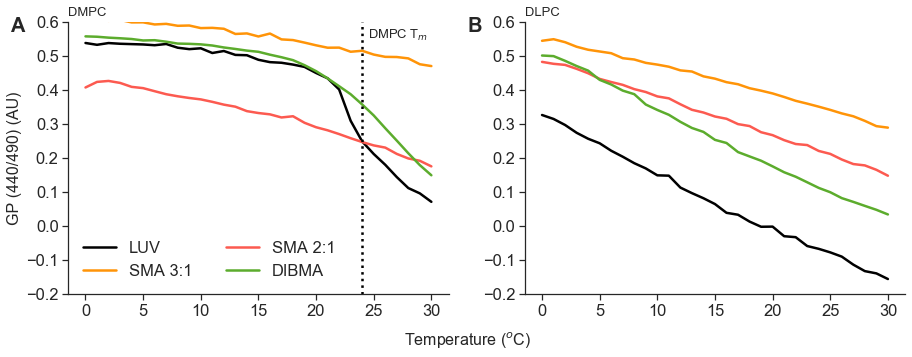

In [7]:
#Now we plot the calculated GP

#We do not need to loop through, as the function aboce returns a 1D array (or list), with one value per temperature
fig, axs = plt.subplots(1, 2, figsize=(15, 5), frameon = True)
#Colours here are the standard colours of the polymers throughout the thesis
axs[0].plot(DMPC_LV_GP, color = colors[0], label = 'LUV')
axs[0].plot(DMPC_LQ_GP, color = colors[6], label ='SMA 3:1')
axs[0].plot(DMPC_21_GP, color = colors[7], label ="SMA 2:1")
axs[0].plot(DMPC_D_GP, color = colors[8], label = "DIBMA")

axs[1].plot(DLPC_LV_GP, color = colors[0], label = 'LUV')
axs[1].plot(DLPC_LQ_GP, color = colors[6], label ='SMA 3:1')
axs[1].plot(DLPC_21_GP, color = colors[7], label ="SMA 2:1")
axs[1].plot(DLPC_D_GP, color = colors[8], label = "DIBMA")

#Annotating the transition temperature of DMPC (to show when the phase change is expected)
#The waterbath heating the sample was checked with three individual thermometers and was within +/-1C for all
axs[0].axvline(x=24, ls = ":", color = colors[0])
axs[0].text(s = "DMPC T$_{m}$", x = 24.5, y = 0.55, fontsize=13)

axs[0].set_title("DMPC", fontsize = 13, loc = 'left')
axs[1].set_title("DLPC", fontsize = 13, loc = 'left')

axs[0].set_ylabel("GP (440/490) (AU)", fontsize = 16)
axs[1].text(s="Temperature ($^{o}$C)", x=-12, y=-.35, fontsize = 16)

#Standardise the axes for easier comparison
axs[0].set_ylim(-.2,.6)
axs[1].set_ylim(-.2,.6)

#Tried out a new, fancier way of labelling the plots for reference in thesis
#Uses the axis parameters alone, rahter than manually finding the value - then can do 90% of the maxima for labels etc
height = axs[0].axis()
position = height[0]-(0.15*(height[1]- height[0]))
axs[0].text(x = position, y = .95*height[3], s = "A", weight = "bold", fontsize = 20)
height = axs[1].axis()
position = height[0]-(0.15*(height[1]- height[0]))
axs[1].text(x = position, y = .95*height[3], s = "B", weight = "bold", fontsize = 20)


#put in legend, remove some axes (despine) for prettiness and save it
axs[0].legend( frameon = False, ncol = 2)
sns.despine()
#plt.savefig('GP_graphs.png', format='png', dpi=300, bbox_inches="tight")
plt.show()